In [1]:
!pip install imblearn

In [2]:
import pandas as pd
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, classification_report, roc_auc_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier

# Import Data

In [4]:
data = pd.read_csv("dataset.csv")
data.head()

Timestamp   Age Primary streaming service  Hours per day  \
0  8/27/2022 19:29:02  18.0                   Spotify            3.0   
1  8/27/2022 19:57:31  63.0                   Pandora            1.5   
2  8/27/2022 21:28:18  18.0                   Spotify            4.0   
3  8/27/2022 21:40:40  61.0             YouTube Music            2.5   
4  8/27/2022 21:54:47  18.0                   Spotify            4.0   

  While working Instrumentalist Composer         Fav genre Exploratory  \
0           Yes             Yes      Yes             Latin         Yes   
1           Yes              No       No              Rock         Yes   
2            No              No       No  Video game music          No   
3           Yes              No      Yes              Jazz         Yes   
4           Yes              No       No               R&B         Yes   

  Foreign languages  ...  Frequency [R&B]  Frequency [Rap] Frequency [Rock]  \
0               Yes  ...        Sometimes  Very frequently            Never   
1                No  ...        Sometimes           Rarely  Very frequently   
2               Yes  ...            Never           Rarely           Rarely   
3               Yes  ...        Sometimes            Never            Never   
4                No  ...  Very frequently  Very frequently            Never   

  Frequency [Video game music] Anxiety Depression Insomnia  OCD Music effects  \
0                    Sometimes     3.0        0.0      1.0  0.0           NaN   
1                       Rarely     7.0        2.0      2.0  1.0           NaN   
2              Very frequently     7.0        7.0     10.0  2.0     No effect   
3                        Never     9.0        7.0      3.0  3.0       Improve   
4                       Rarely     7.0        2.0      5.0  9.0       Improve   

     Permissions  
0  I understand.  
1  I understand.  
2  I understand.  
3  I understand.  
4  I understand.  

[5 rows x 33 columns]

In [5]:
target_variable = 'Music effects'

# Data Exploration

In [7]:
data.shape

(736, 33)

In [8]:
data[target_variable].value_counts()

Music effects
Improve      542
No effect    169
Worsen        17
Name: count, dtype: int64

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 736 entries, 0 to 735
Data columns (total 33 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Timestamp                     736 non-null    object 
 1   Age                           735 non-null    float64
 2   Primary streaming service     735 non-null    object 
 3   Hours per day                 736 non-null    float64
 4   While working                 733 non-null    object 
 5   Instrumentalist               732 non-null    object 
 6   Composer                      735 non-null    object 
 7   Fav genre                     736 non-null    object 
 8   Exploratory                   736 non-null    object 
 9   Foreign languages             732 non-null    object 
 10  BPM                           629 non-null    float64
 11  Frequency [Classical]         736 non-null    object 
 12  Frequency [Country]           736 non-null    object 
 13  Frequ

<Axes: xlabel='Music effects'>

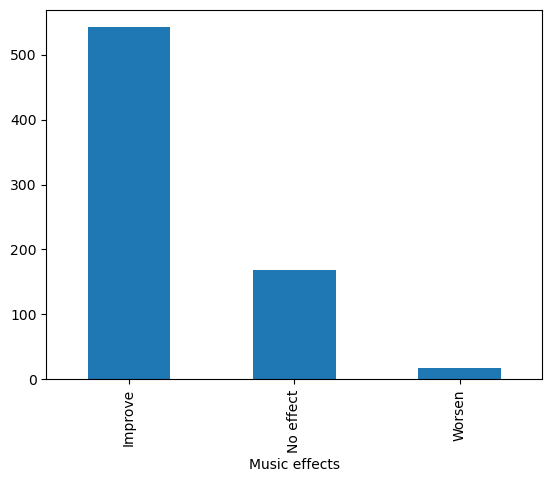

In [10]:
data[target_variable].value_counts().plot(kind='bar')

In [11]:
numerical_cols = data.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_cols = [col for col in numerical_cols if col not in ['BPM', 'Anxiety', 'Depression', 'Insomnia', 'OCD']]

categorical_cols = data.select_dtypes(include=['object']).columns.tolist()
categorical_cols = [col for col in categorical_cols if col not in ['Timestamp', 'Music effects', 'Permissions']]

print('Numerical columns: ', numerical_cols)
print('\nCategorical columns: ', categorical_cols)

Numerical columns:  ['Age', 'Hours per day']

Categorical columns:  ['Primary streaming service', 'While working', 'Instrumentalist', 'Composer', 'Fav genre', 'Exploratory', 'Foreign languages', 'Frequency [Classical]', 'Frequency [Country]', 'Frequency [EDM]', 'Frequency [Folk]', 'Frequency [Gospel]', 'Frequency [Hip hop]', 'Frequency [Jazz]', 'Frequency [K pop]', 'Frequency [Latin]', 'Frequency [Lofi]', 'Frequency [Metal]', 'Frequency [Pop]', 'Frequency [R&B]', 'Frequency [Rap]', 'Frequency [Rock]', 'Frequency [Video game music]']


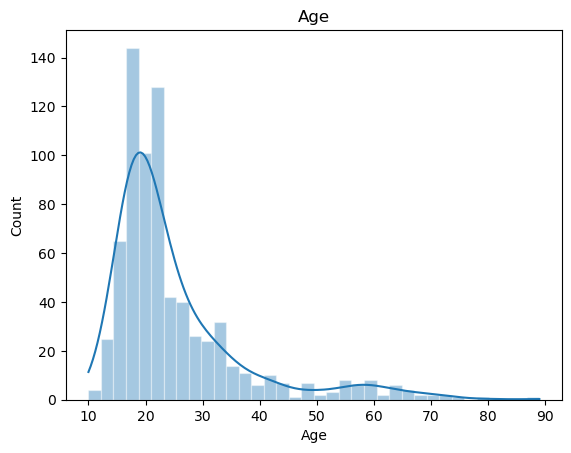

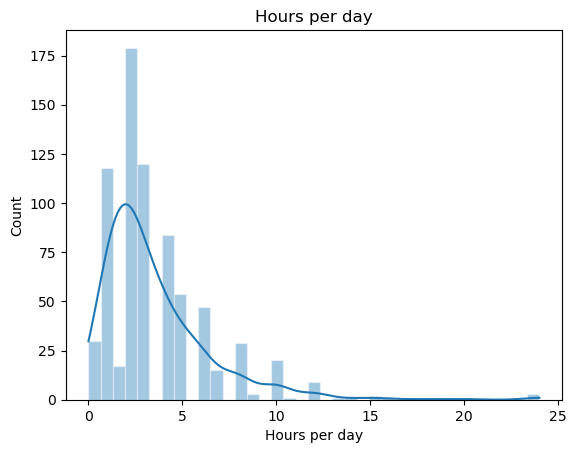

In [12]:
for col in numerical_cols:
    col_data = data[col].dropna()
    sns.histplot(col_data, kde=True, alpha=.4, edgecolor=(1, 1, 1, .4))
    plt.title(col)
    plt.show()

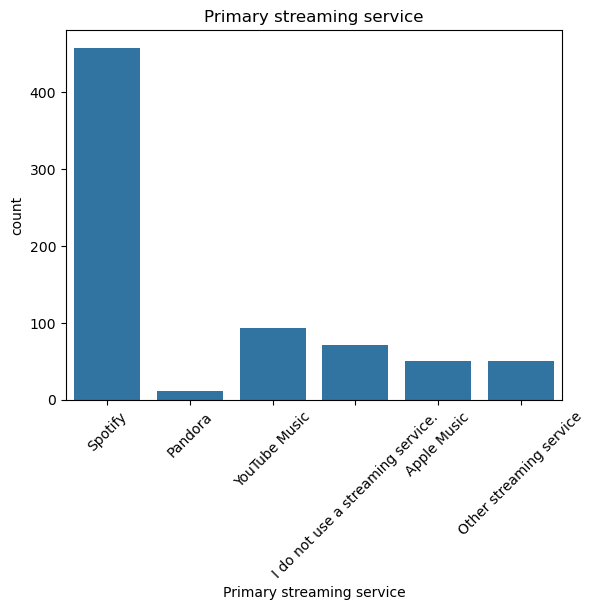

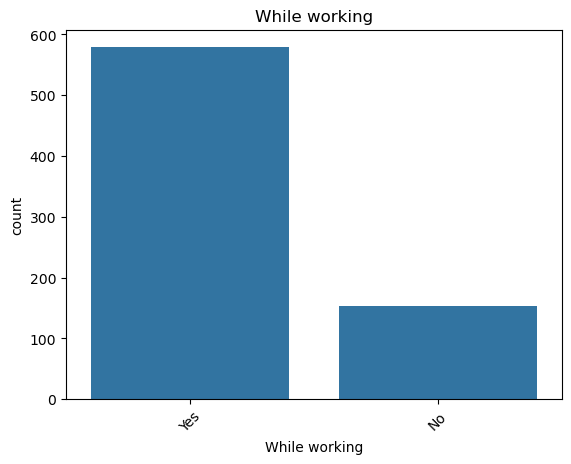

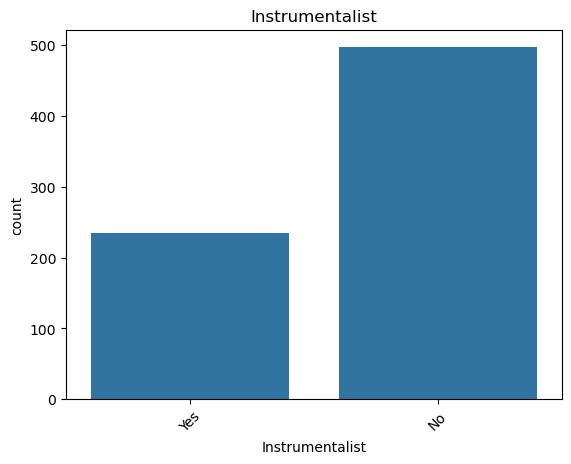

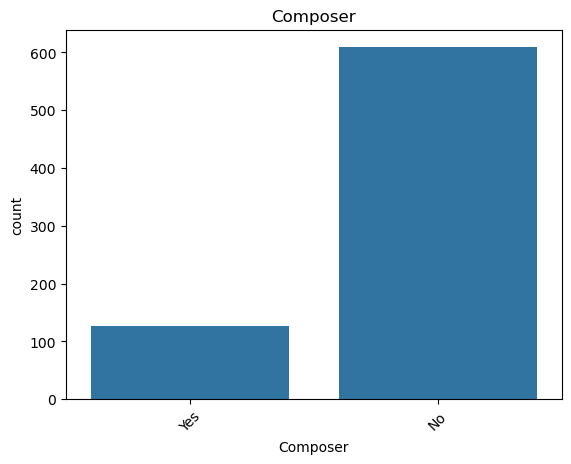

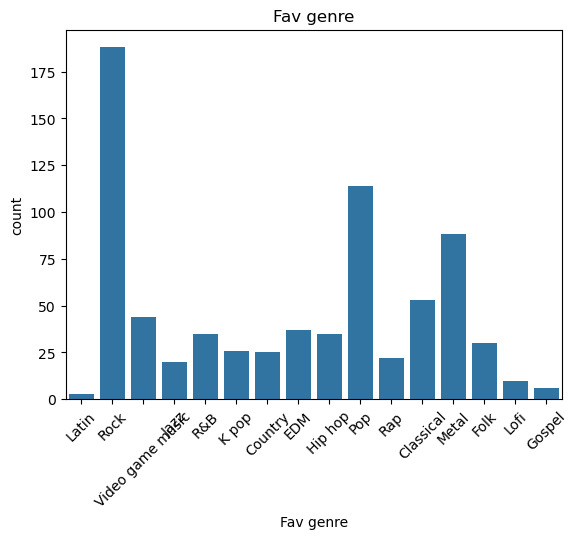

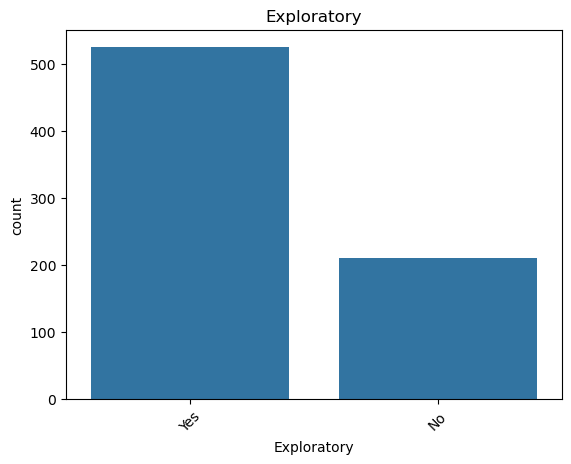

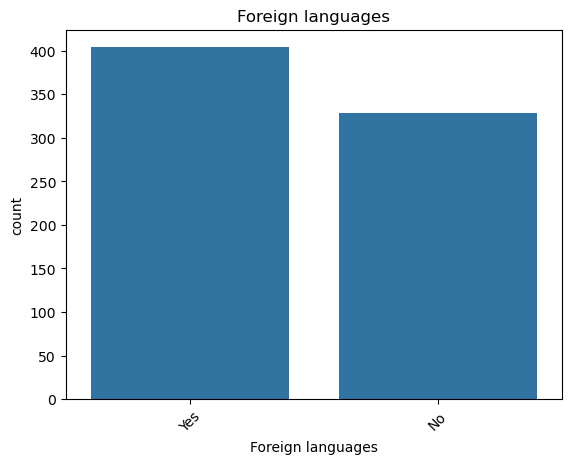

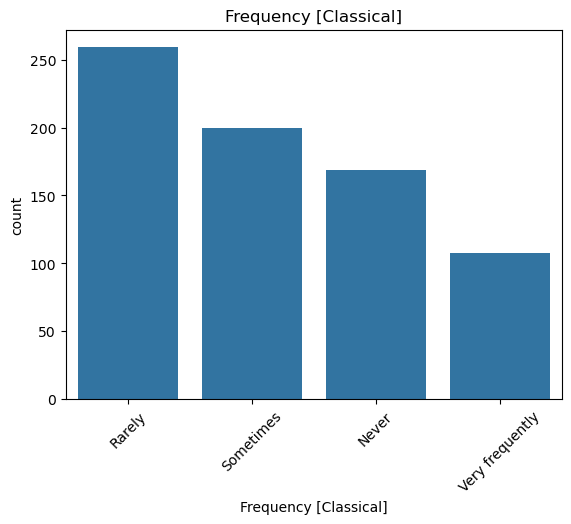

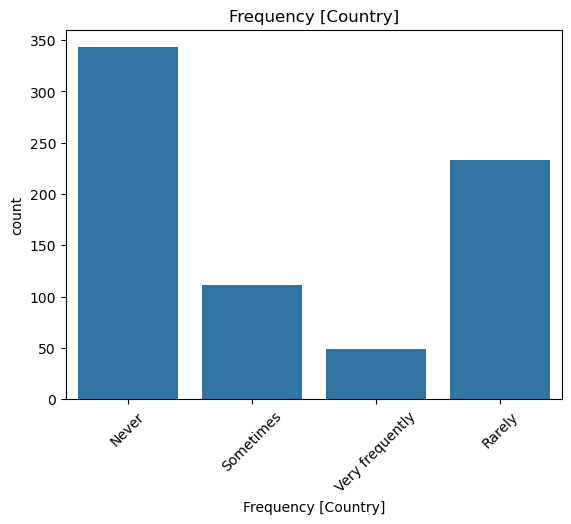

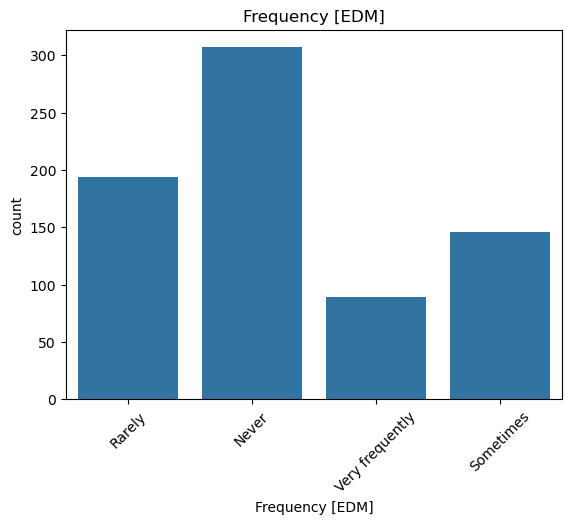

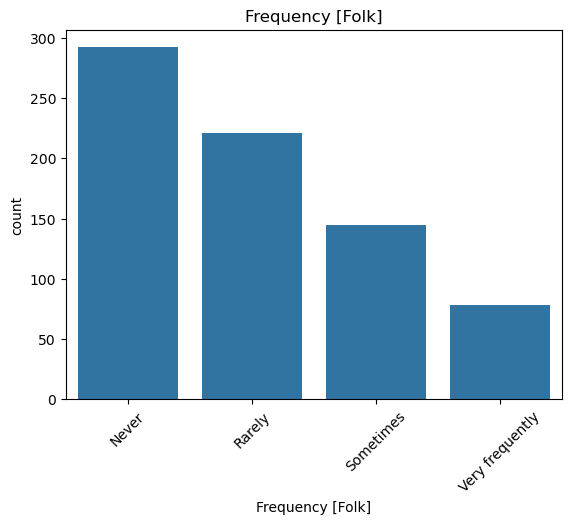

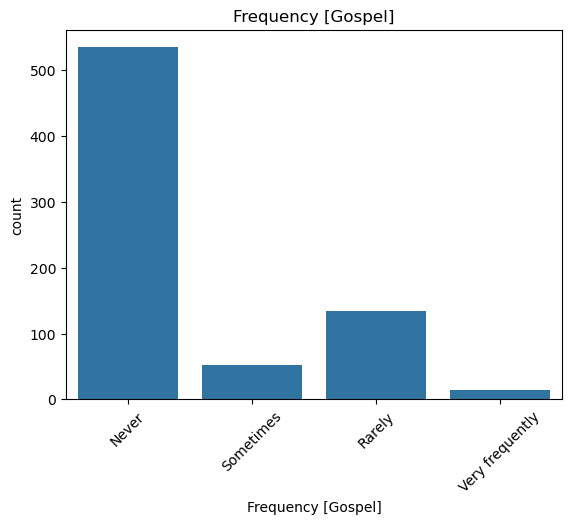

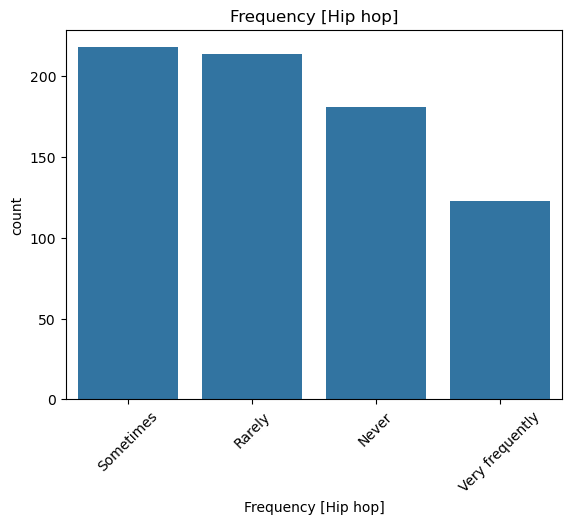

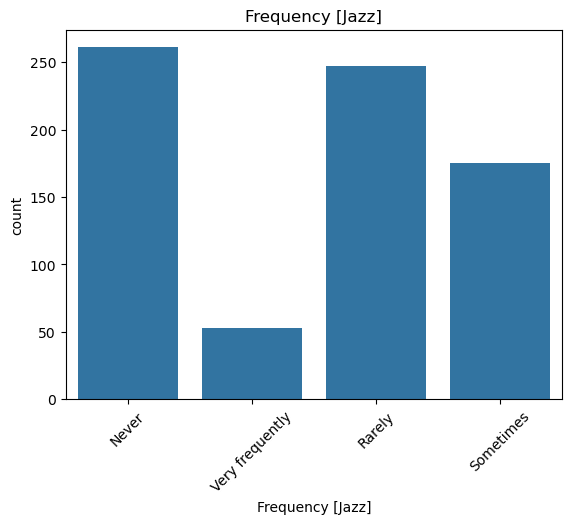

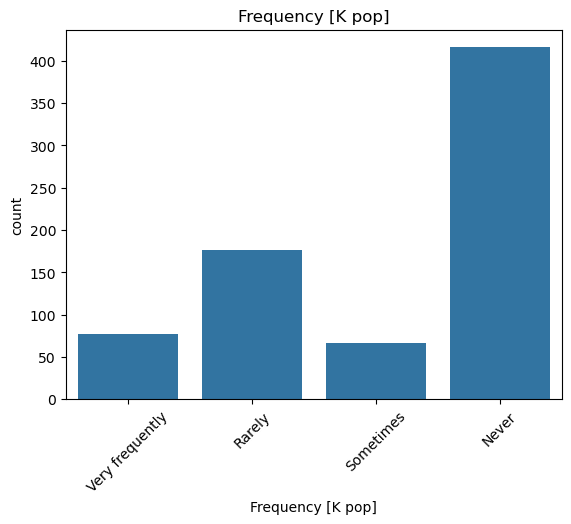

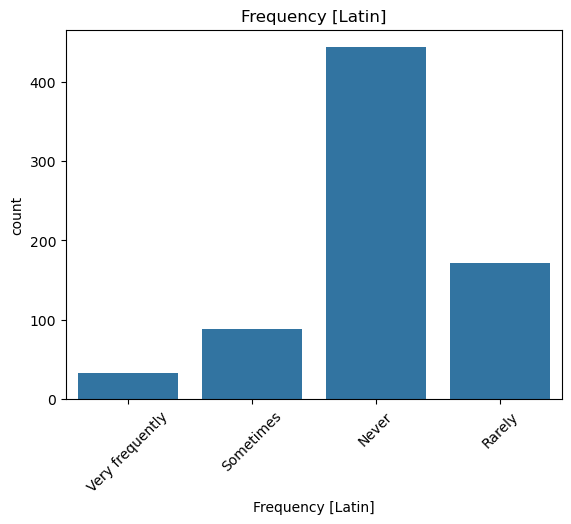

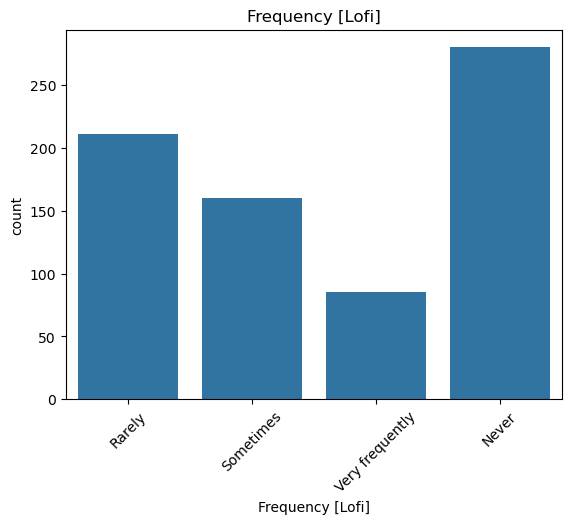

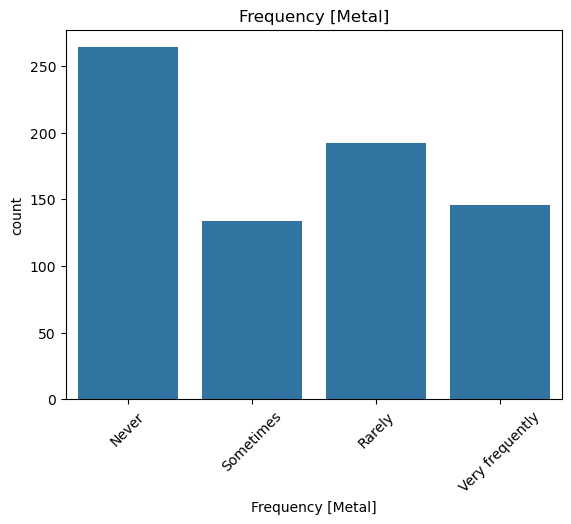

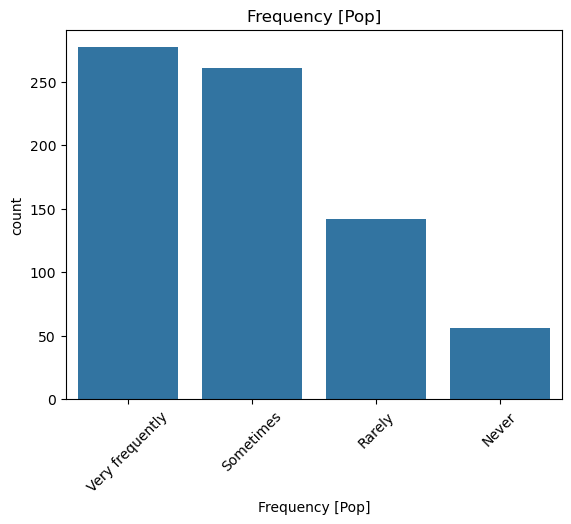

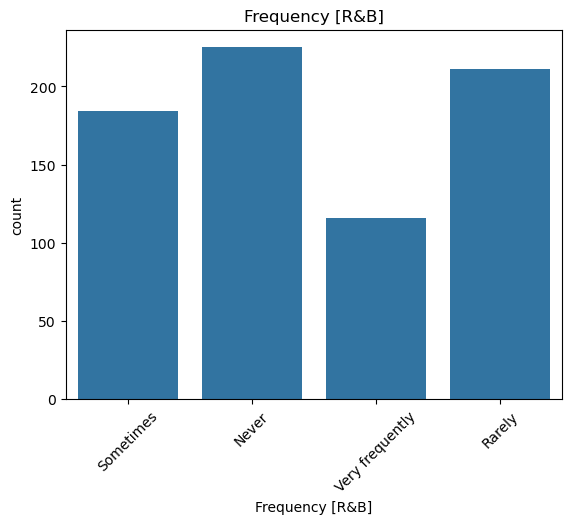

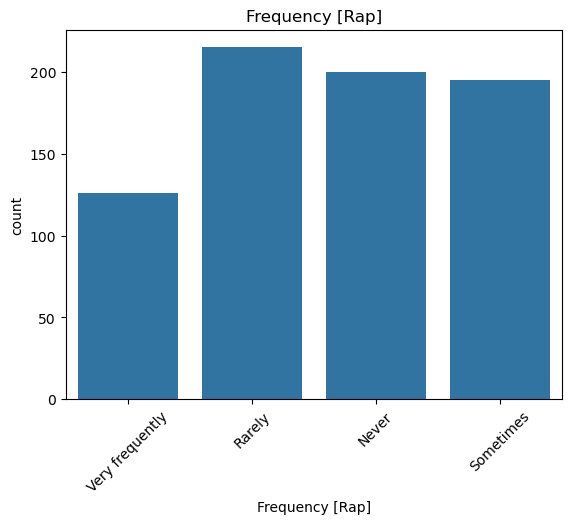

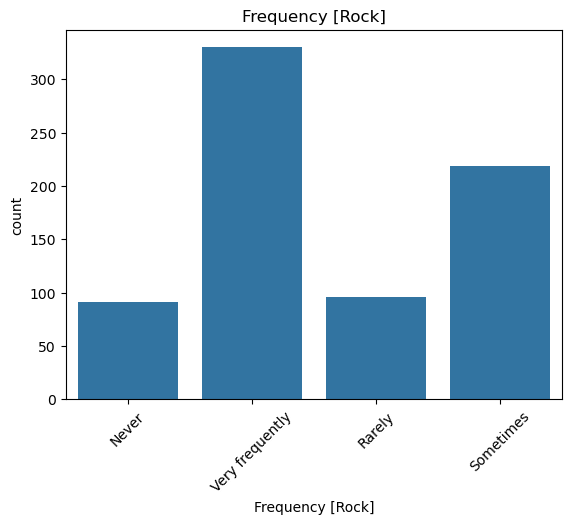

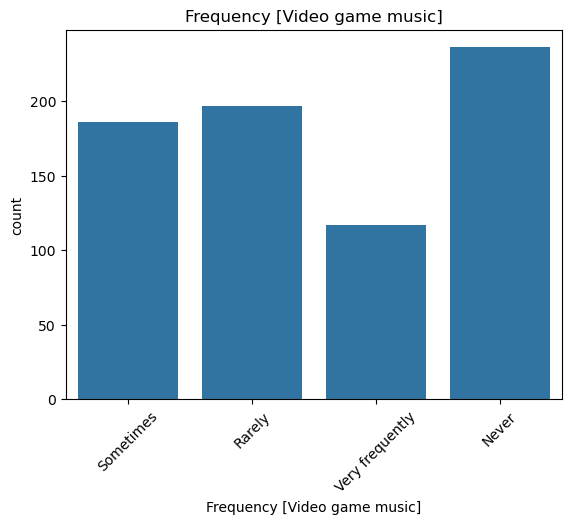

In [13]:
for col in categorical_cols:
    sns.countplot(data=data, x=col)
    plt.title(col)
    plt.xticks(rotation=45)
    plt.show()

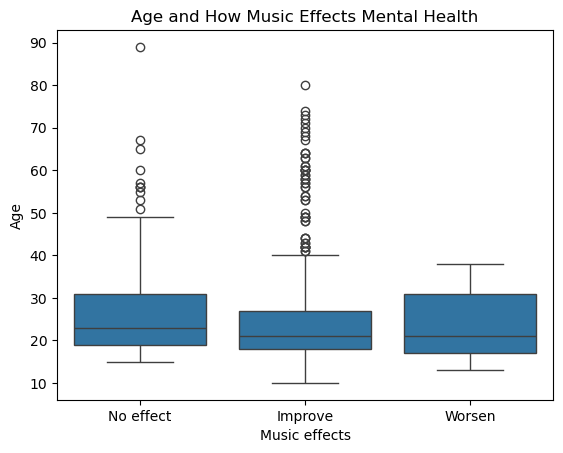

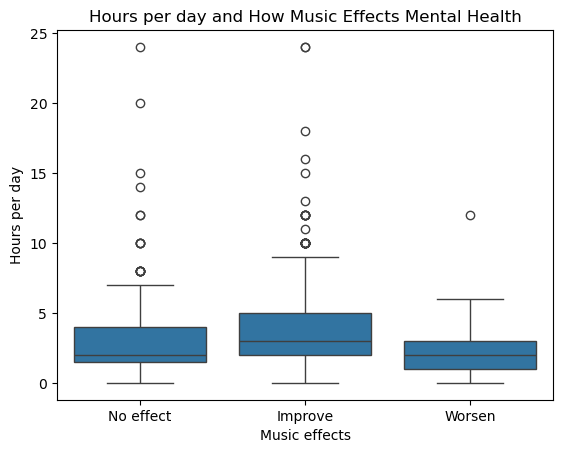

In [14]:
for col in numerical_cols:
    sns.boxplot(data=data, x=target_variable, y=col)
    plt.title(f'{col} and How Music Effects Mental Health')
    plt.show()

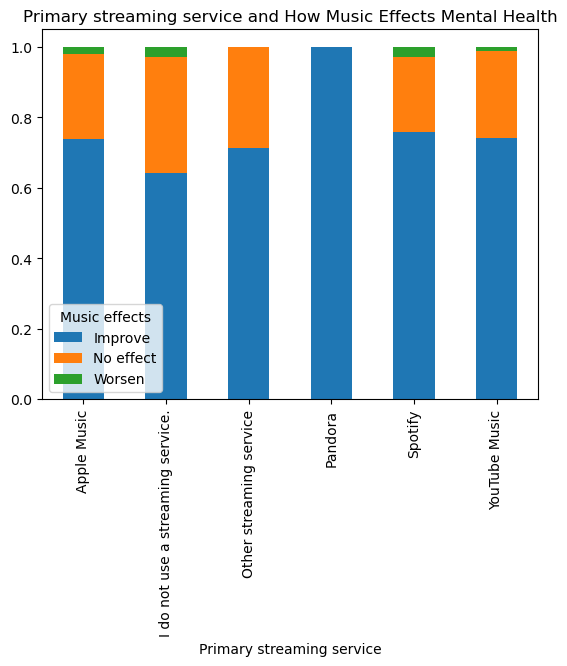

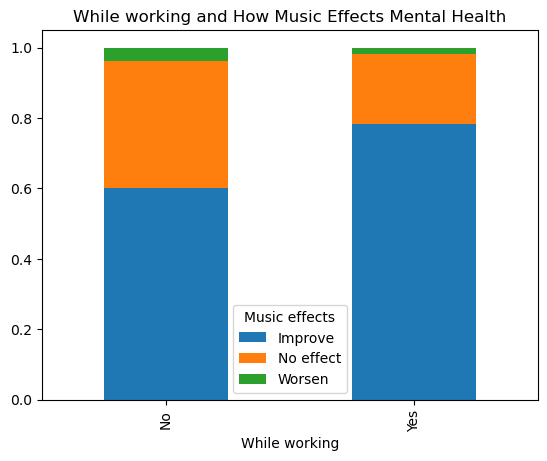

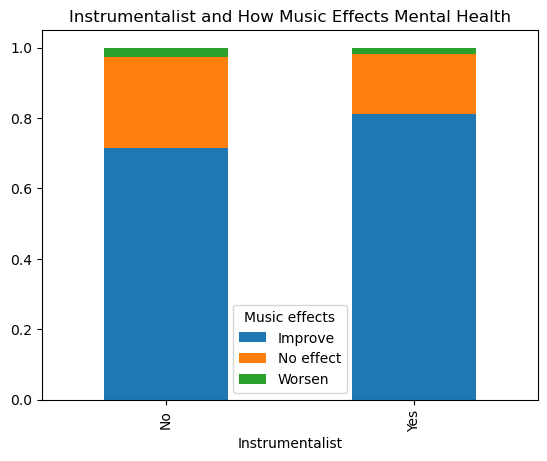

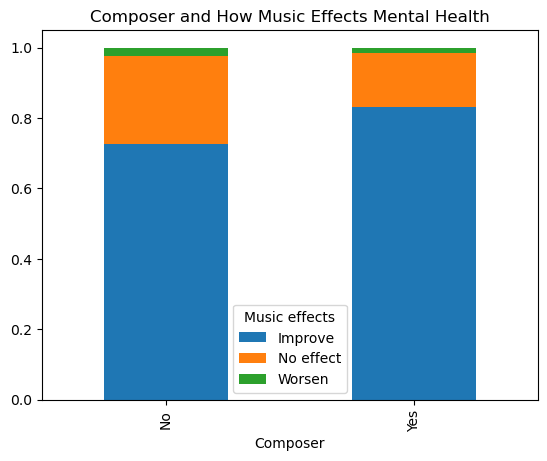

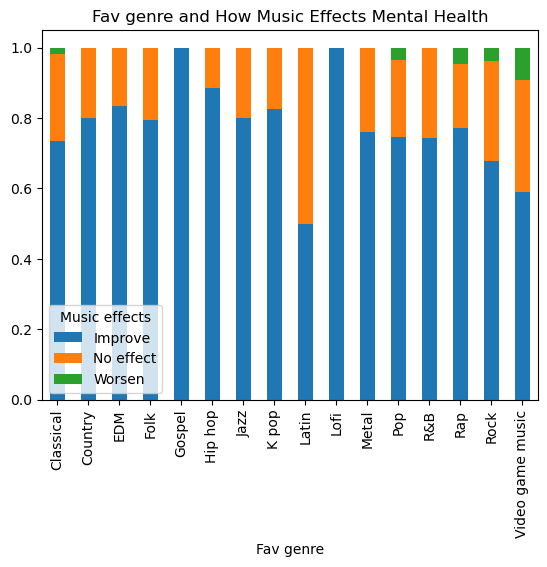

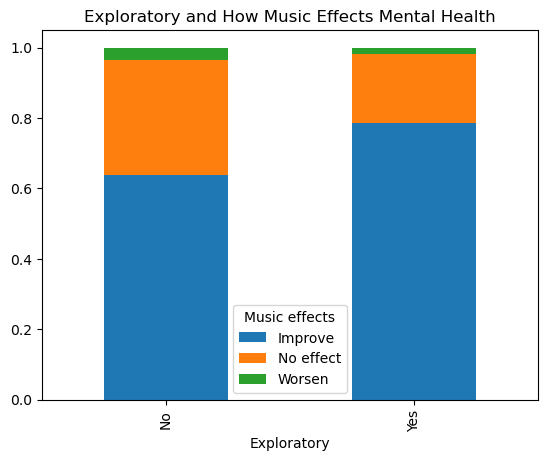

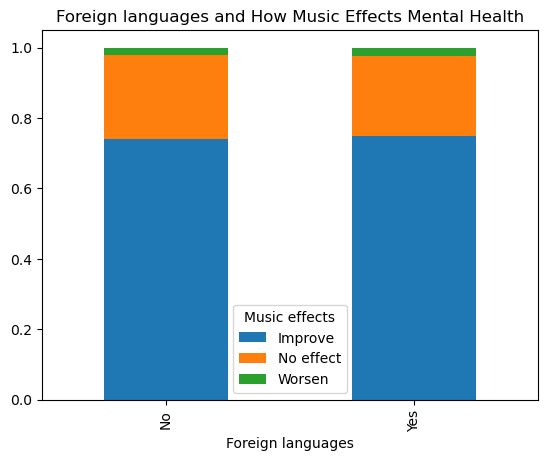

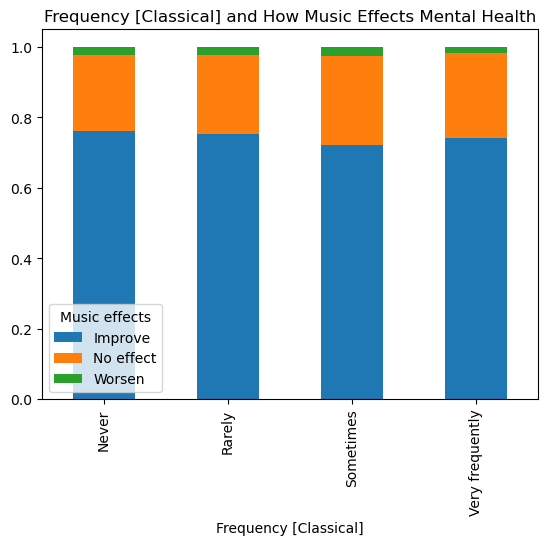

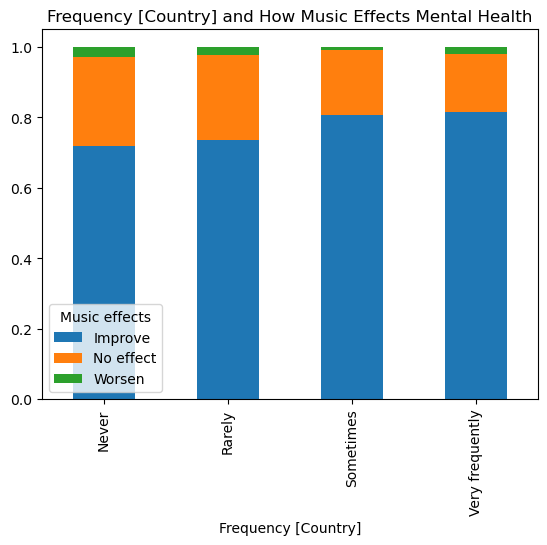

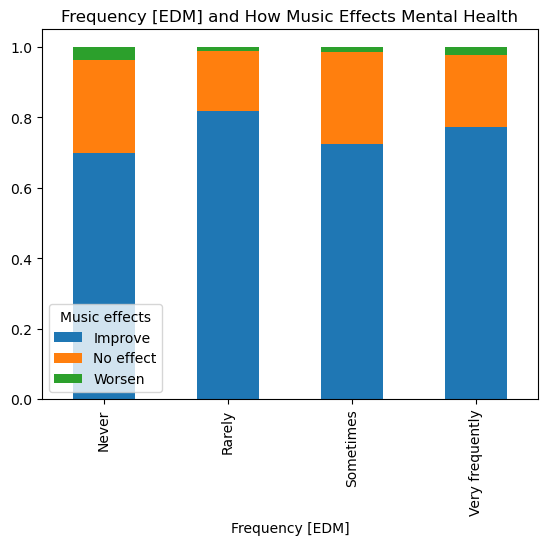

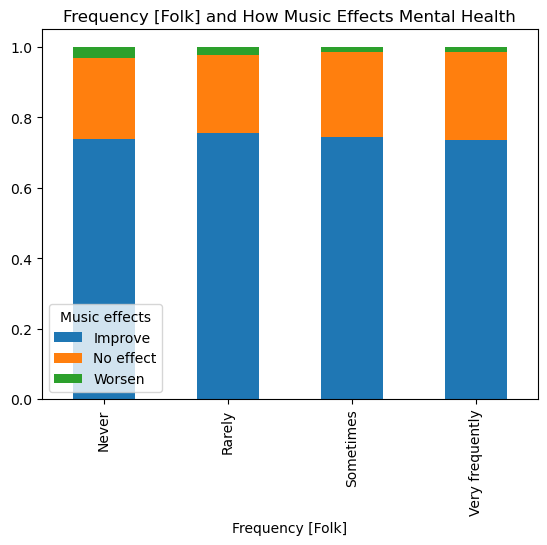

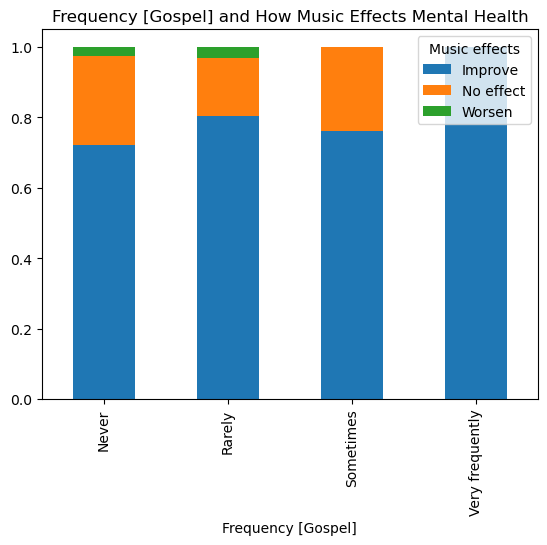

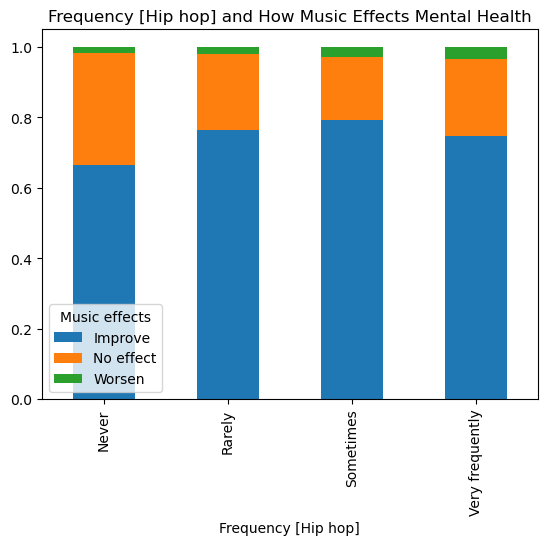

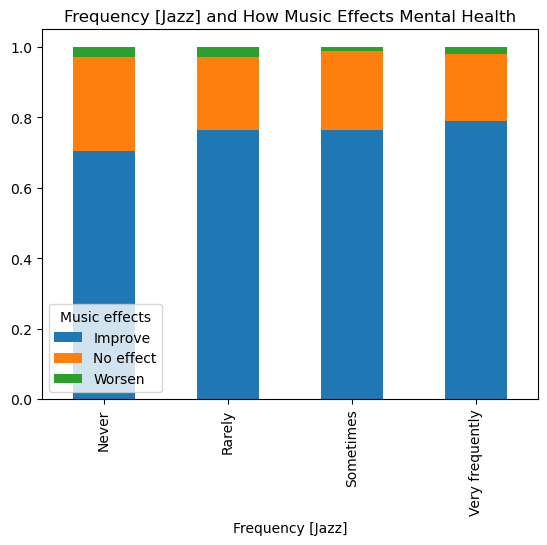

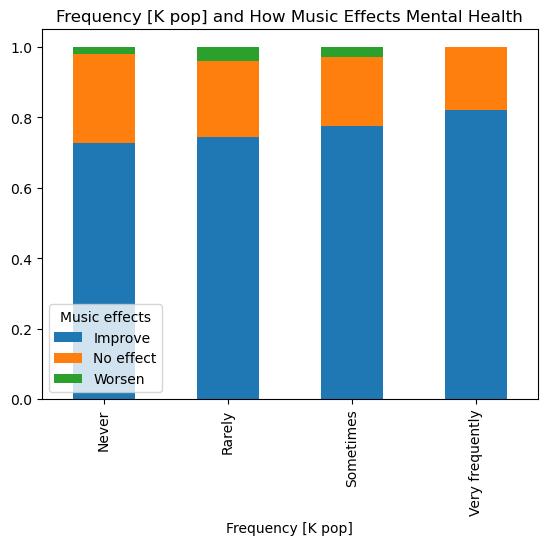

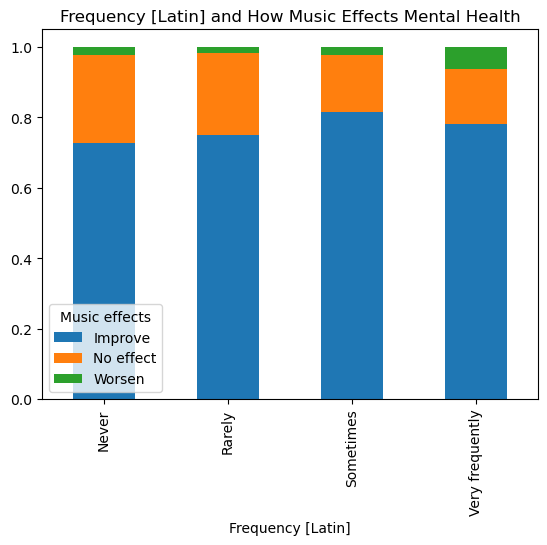

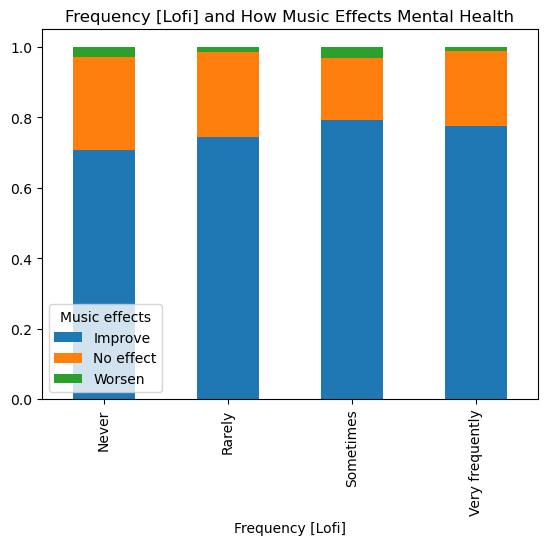

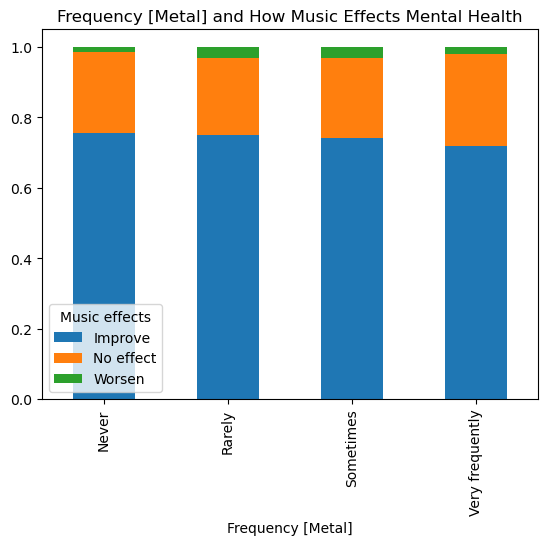

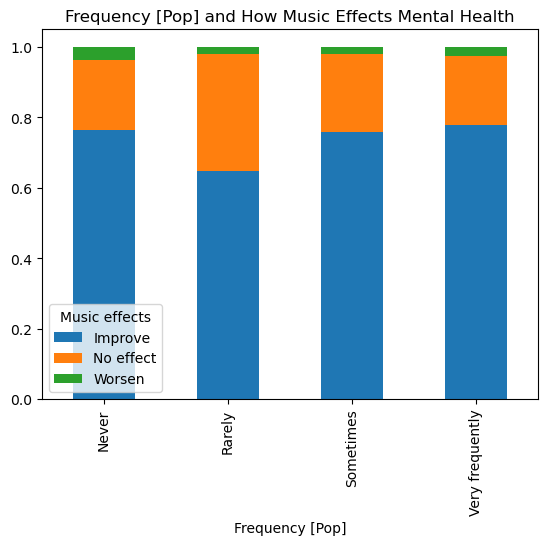

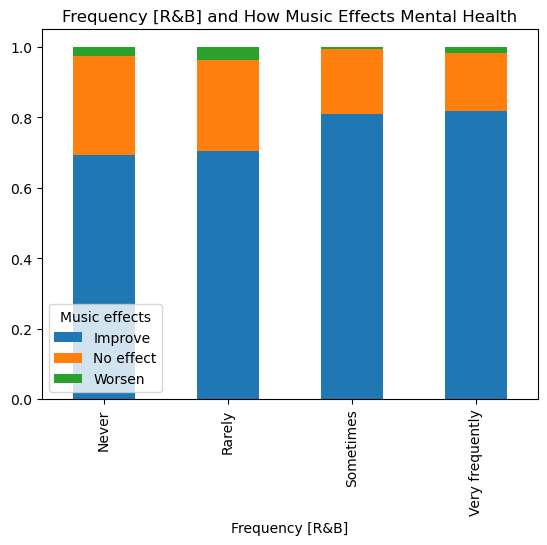

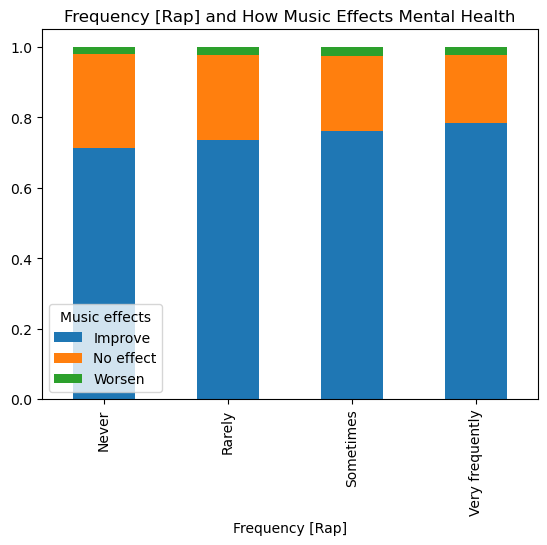

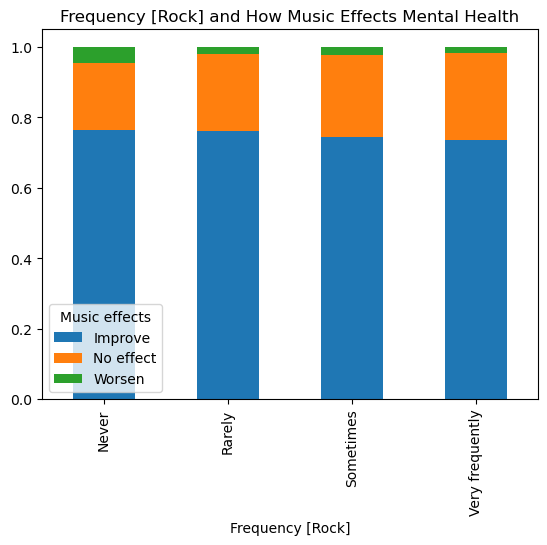

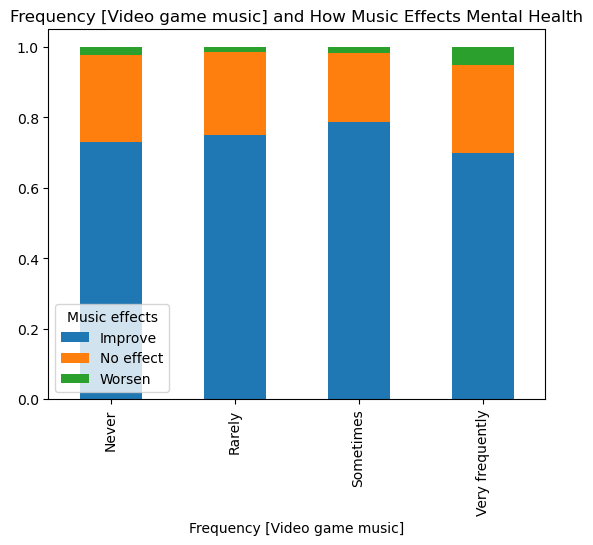

In [15]:
for col in categorical_cols:
    pd.crosstab(data[col], data[target_variable], normalize='index').plot(kind='bar', stacked=True)
    plt.title(f'{col} and How Music Effects Mental Health')
    plt.show()

# Data Preprocessing

In [17]:
null_counts = data.isnull().sum()
print("Null counts")
null_counts[null_counts > 0]

Null counts


Age                            1
Primary streaming service      1
While working                  3
Instrumentalist                4
Composer                       1
Foreign languages              4
BPM                          107
Music effects                  8
dtype: int64

In [18]:
data = data.dropna(subset=['Music effects'])
# convert to binary Improve vs Not Improve
data['Music effects'] = data['Music effects'].replace({
    'No effect': 'Not Improve',
    'Worsen': 'Not Improve'
})

le = LabelEncoder()
data['Music effects'] = le.fit_transform(data['Music effects'])

In [19]:
data = data.drop(["Permissions"],axis=1)
data = data.drop(["Timestamp"],axis=1)
# since we are predicting mental health outcomes, we don't need any related columns
data = data.drop(["Anxiety"],axis=1)
data = data.drop(["Depression"],axis=1)
data = data.drop(["Insomnia"],axis=1)
data = data.drop(["OCD"],axis=1)

In [20]:
data['Age'] = data['Age'].fillna(data['Age'].mean())

In [21]:
# since most songs in a genre usually fall within a certain BPM range, we will replace all null BPM column with the average for that row's genre
fav_genre_bpm_mean = data.groupby('Fav genre')['BPM'].mean()
fav_genre_bpm_mean

Fav genre
Classical           1.145750e+02
Country             1.101905e+02
EDM                 1.475000e+02
Folk                1.097200e+02
Gospel              8.925000e+01
Hip hop             1.119062e+02
Jazz                1.244737e+02
K pop               1.294783e+02
Latin               1.225000e+02
Lofi                1.143000e+02
Metal               1.391026e+02
Pop                 1.189072e+02
R&B                 1.141667e+02
Rap                 1.271000e+02
Rock                1.240867e+02
Video game music    2.702714e+07
Name: BPM, dtype: float64

In [22]:
fav_genre_bpm_dict = fav_genre_bpm_mean.to_dict()
fav_genre_bpm_dict

{'Classical': 114.575,
 'Country': 110.19047619047619,
 'EDM': 147.5,
 'Folk': 109.72,
 'Gospel': 89.25,
 'Hip hop': 111.90625,
 'Jazz': 124.47368421052632,
 'K pop': 129.47826086956522,
 'Latin': 122.5,
 'Lofi': 114.3,
 'Metal': 139.10256410256412,
 'Pop': 118.90721649484536,
 'R&B': 114.16666666666667,
 'Rap': 127.1,
 'Rock': 124.08666666666667,
 'Video game music': 27027143.513513513}

In [23]:
def fill_bpm(row):
    if pd.isnull(row['BPM']):
        return fav_genre_bpm_dict.get(row['Fav genre'], data['BPM'].mean().round())
    return row['BPM']

In [24]:
data['BPM'] = data.apply(fill_bpm, axis=1)

In [25]:
null_counts = data.isnull().sum()
print("Null counts")
null_counts[null_counts > 0]

Null counts


Primary streaming service    1
While working                2
Instrumentalist              3
Foreign languages            3
dtype: int64

In [26]:
missing_val_cols = null_counts[null_counts > 0].to_dict().keys()
missing_val_cols

dict_keys(['Primary streaming service', 'While working', 'Instrumentalist', 'Foreign languages'])

In [27]:
for col in missing_val_cols:
    data[col] = data[col].fillna(data[col].mode()[0])

In [28]:
yes_or_no_cols = ['While working', 'Instrumentalist', 'Composer', 'Exploratory', 'Foreign languages']

for col in yes_or_no_cols:
    data[col] = data[col].map({'Yes': 1, 'No': 0})

In [29]:
data = pd.get_dummies(data, columns=['Primary streaming service'], prefix='Streaming Service', drop_first=False)
data = pd.get_dummies(data, columns=['Fav genre'], prefix='Fav Genre', drop_first=False)

In [30]:
data['Frequency [Pop]'].value_counts()

Frequency [Pop]
Very frequently    274
Sometimes          257
Rarely             142
Never               55
Name: count, dtype: int64

In [31]:
frequency_cols = [col for col in data.columns if col.startswith('Frequency')]
frequency_cols

['Frequency [Classical]',
 'Frequency [Country]',
 'Frequency [EDM]',
 'Frequency [Folk]',
 'Frequency [Gospel]',
 'Frequency [Hip hop]',
 'Frequency [Jazz]',
 'Frequency [K pop]',
 'Frequency [Latin]',
 'Frequency [Lofi]',
 'Frequency [Metal]',
 'Frequency [Pop]',
 'Frequency [R&B]',
 'Frequency [Rap]',
 'Frequency [Rock]',
 'Frequency [Video game music]']

In [32]:
frequency_value_map = {
    'Very frequently': 3,
    'Sometimes': 2,
    'Rarely': 1,
    'Never': 0
}

for col in frequency_cols:
    data[col] = data[col].map(frequency_value_map)

In [33]:
data.head()

Age  Hours per day  While working  Instrumentalist  Composer  Exploratory  \
2  18.0            4.0              0                0         0            0   
3  61.0            2.5              1                0         1            1   
4  18.0            4.0              1                0         0            1   
5  18.0            5.0              1                1         1            1   
6  18.0            3.0              1                1         0            1   

   Foreign languages    BPM  Frequency [Classical]  Frequency [Country]  ...  \
2                  1  132.0                      0                    0  ...   
3                  1   84.0                      2                    0  ...   
4                  0  107.0                      0                    0  ...   
5                  1   86.0                      1                    2  ...   
6                  1   66.0                      2                    0  ...   

   Fav Genre_Jazz  Fav Genre_K pop  Fav Genre_Latin  Fav Genre_Lofi  \
2           False            False            False           False   
3            True            False            False           False   
4           False            False            False           False   
5            True            False            False           False   
6           False            False            False           False   

   Fav Genre_Metal  Fav Genre_Pop  Fav Genre_R&B  Fav Genre_Rap  \
2            False          False          False          False   
3            False          False          False          False   
4            False          False           True          False   
5            False          False          False          False   
6            False          False          False          False   

   Fav Genre_Rock  Fav Genre_Video game music  
2           False                        True  
3           False                       False  
4           False                       False  
5           False                       False  
6           False                        True  

[5 rows x 47 columns]

In [34]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 728 entries, 2 to 735
Data columns (total 47 columns):
 #   Column                                               Non-Null Count  Dtype  
---  ------                                               --------------  -----  
 0   Age                                                  728 non-null    float64
 1   Hours per day                                        728 non-null    float64
 2   While working                                        728 non-null    int64  
 3   Instrumentalist                                      728 non-null    int64  
 4   Composer                                             728 non-null    int64  
 5   Exploratory                                          728 non-null    int64  
 6   Foreign languages                                    728 non-null    int64  
 7   BPM                                                  728 non-null    float64
 8   Frequency [Classical]                                728 non-null    int64 

In [35]:
data.describe()

Age  Hours per day  While working  Instrumentalist    Composer  \
count  728.000000     728.000000     728.000000       728.000000  728.000000   
mean    25.143054       3.591415       0.789835         0.318681    0.171703   
std     11.919787       3.038554       0.407706         0.466286    0.377382   
min     10.000000       0.000000       0.000000         0.000000    0.000000   
25%     18.000000       2.000000       1.000000         0.000000    0.000000   
50%     21.000000       3.000000       1.000000         0.000000    0.000000   
75%     28.000000       5.000000       1.000000         1.000000    0.000000   
max     89.000000      24.000000       1.000000         1.000000    1.000000   

       Exploratory  Foreign languages           BPM  Frequency [Classical]  \
count   728.000000         728.000000  7.280000e+02             728.000000   
mean      0.715659           0.553571  1.633624e+06               1.336538   
std       0.451410           0.497464  3.714669e+07               0.991399   
min       0.000000           0.000000  0.000000e+00               0.000000   
25%       0.000000           0.000000  1.040000e+02               1.000000   
50%       1.000000           1.000000  1.200000e+02               1.000000   
75%       1.000000           1.000000  1.400000e+02               2.000000   
max       1.000000           1.000000  1.000000e+09               3.000000   

       Frequency [Country]  ...  Frequency [K pop]  Frequency [Latin]  \
count           728.000000  ...         728.000000         728.000000   
mean              0.818681  ...           0.725275           0.603022   
std               0.923532  ...           0.993137           0.860467   
min               0.000000  ...           0.000000           0.000000   
25%               0.000000  ...           0.000000           0.000000   
50%               1.000000  ...           0.000000           0.000000   
75%               1.000000  ...           1.000000           1.000000   
max               3.000000  ...           3.000000           3.000000   

       Frequency [Lofi]  Frequency [Metal]  Frequency [Pop]  Frequency [R&B]  \
count        728.000000         728.000000       728.000000       728.000000   
mean           1.068681           1.226648         2.030220         1.255495   
std            1.030862           1.135644         0.934833         1.061051   
min            0.000000           0.000000         0.000000         0.000000   
25%            0.000000           0.000000         1.000000         0.000000   
50%            1.000000           1.000000         2.000000         1.000000   
75%            2.000000           2.000000         3.000000         2.000000   
max            3.000000           3.000000         3.000000         3.000000   

       Frequency [Rap]  Frequency [Rock]  Frequency [Video game music]  \
count       728.000000        728.000000                    728.000000   
mean          1.336538          2.074176                      1.251374   
std           1.054595          1.033147                      1.071706   
min           0.000000          0.000000                      0.000000   
25%           0.000000          1.000000                      0.000000   
50%           1.000000          2.000000                      1.000000   
75%           2.000000          3.000000                      2.000000   
max           3.000000          3.000000                      3.000000   

       Music effects  
count     728.000000  
mean        0.255495  
std         0.436439  
min         0.000000  
25%         0.000000  
50%         0.000000  
75%         1.000000  
max         1.000000  

[8 rows x 25 columns]

In [36]:
null_counts = data.isnull().sum()
print("Null counts")
null_counts[null_counts > 0]

Null counts


Series([], dtype: int64)

## Heatmap

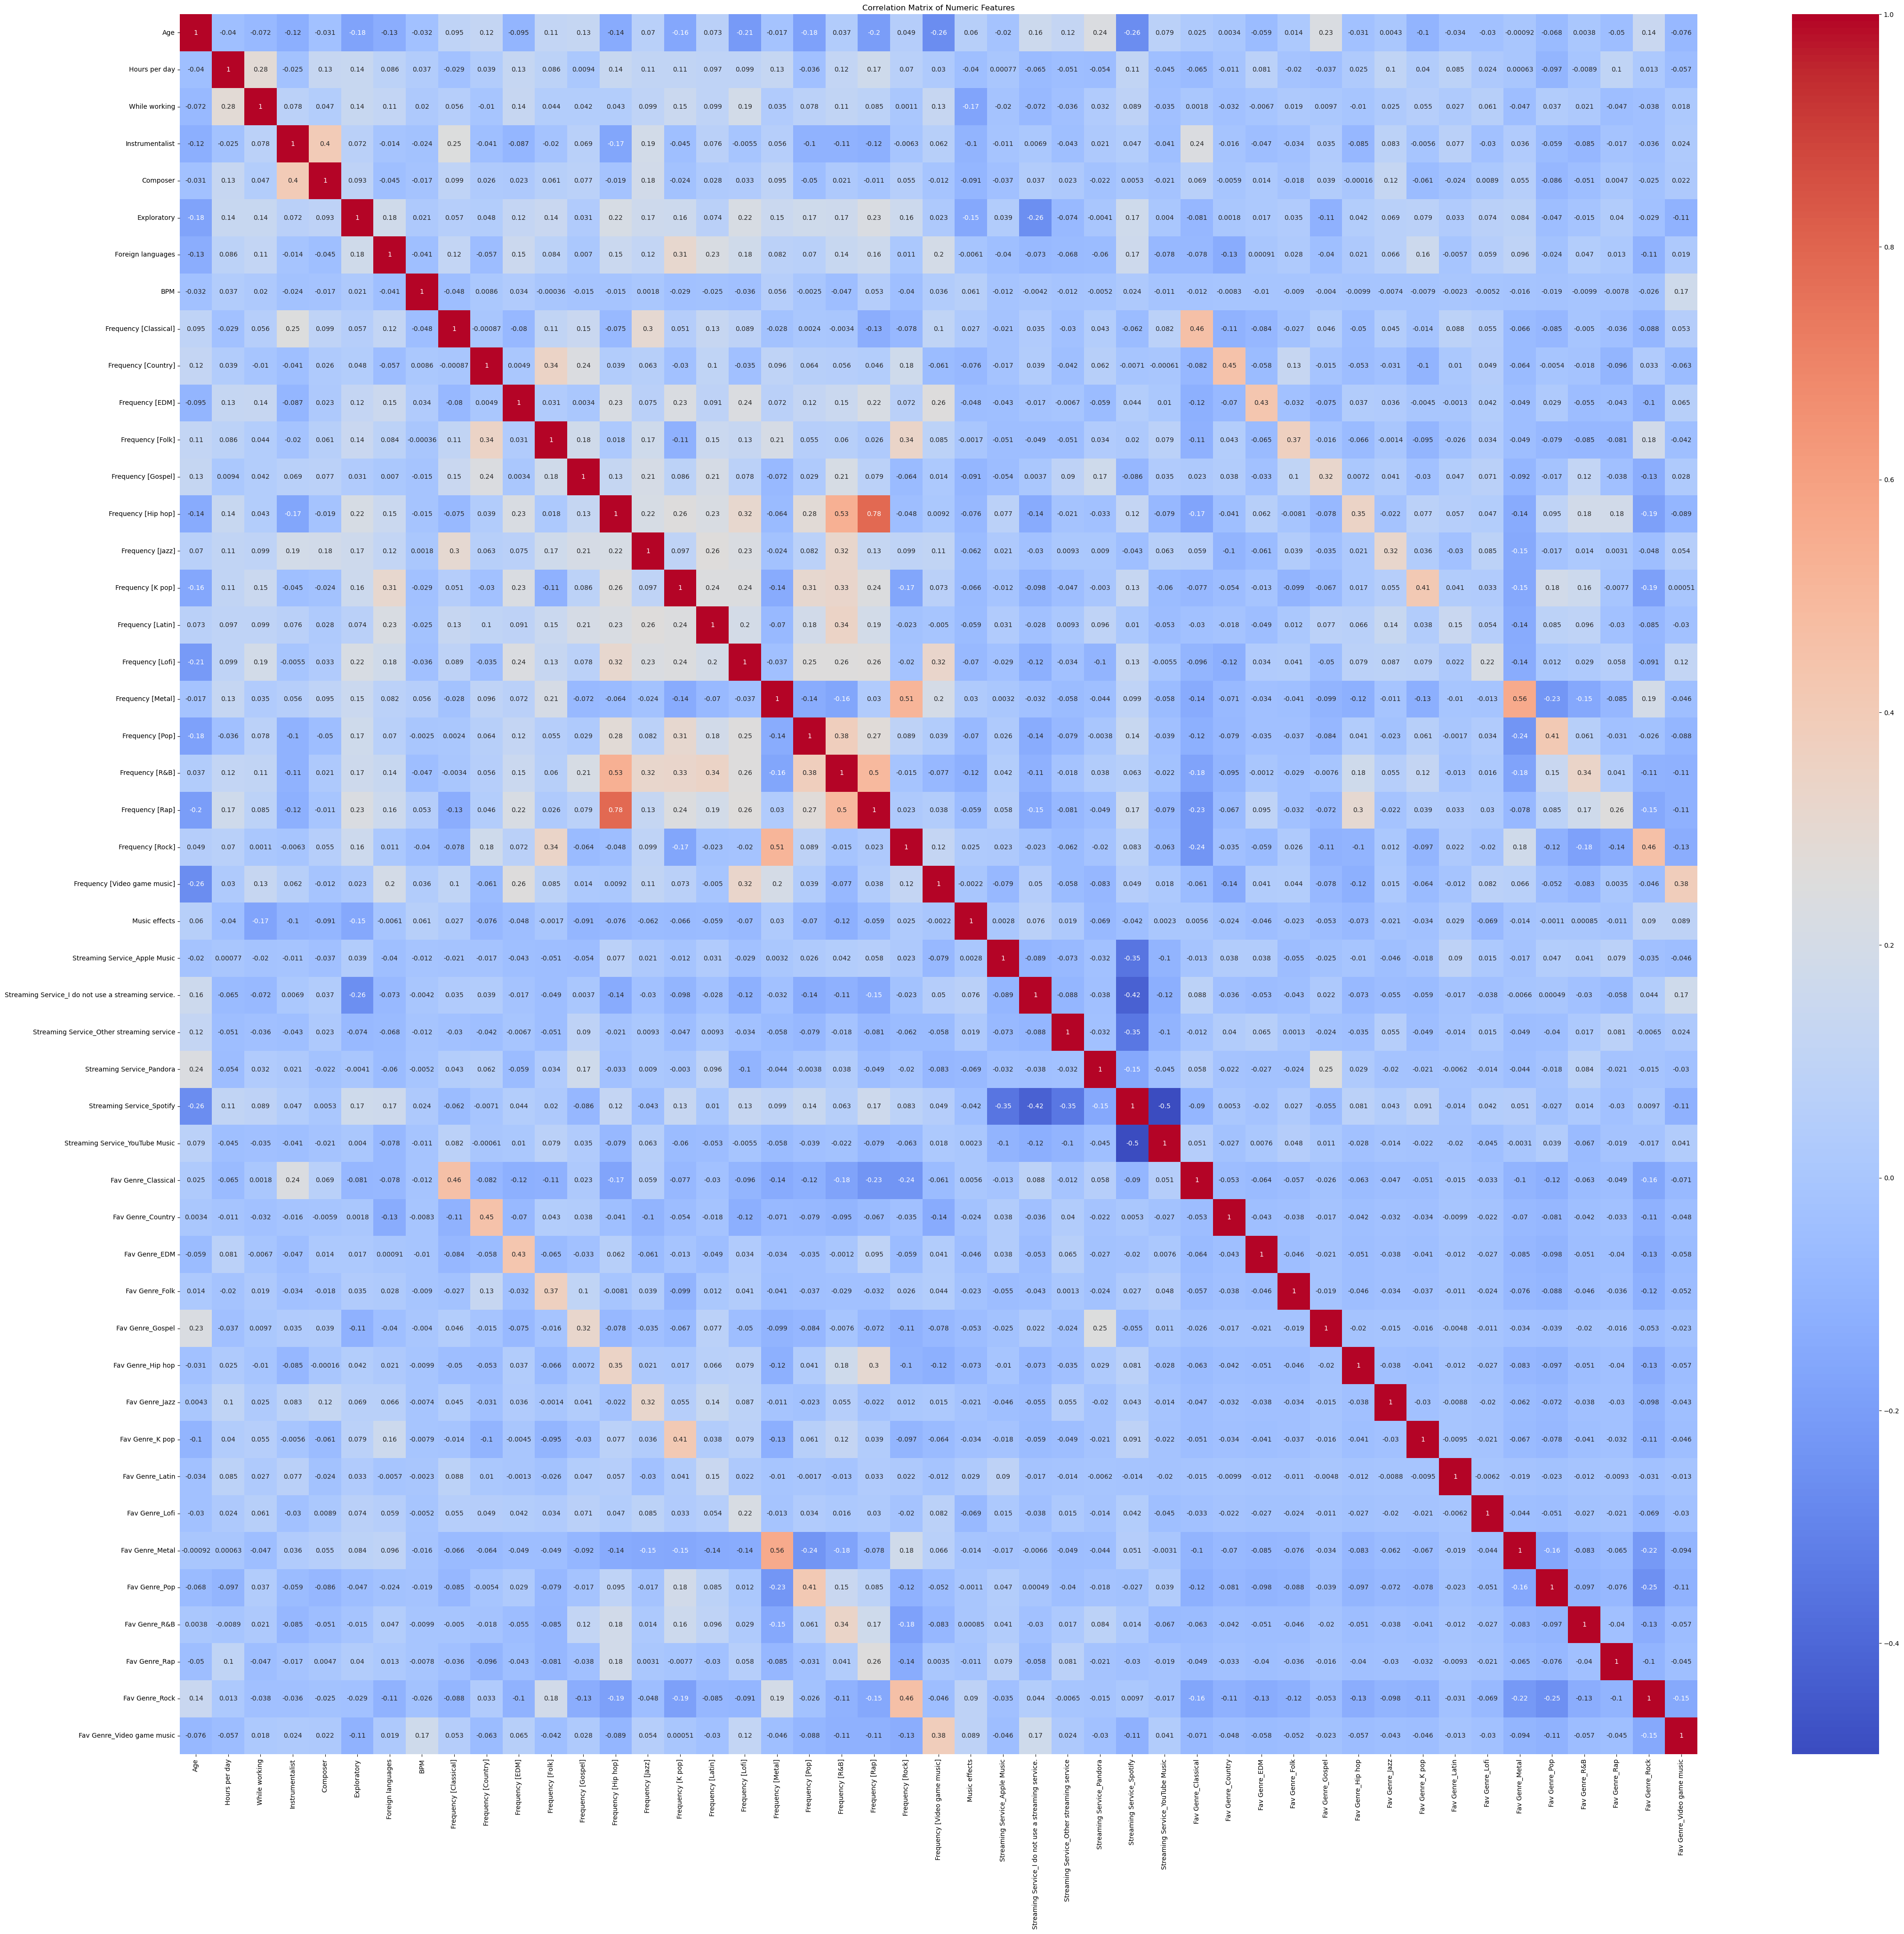

In [72]:
plt.figure(figsize=(52,48))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Numeric Features')
plt.show()

# Modeling

In [75]:
X = data.drop('Music effects', axis=1)
y = data['Music effects']

In [77]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [79]:
# Improve has 542 rows while No Improve has 186, so we need to balance the data counts to get better predictions
# use SMOTE to sythentically add data that does not improve the mental condition
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

## Split the data

In [82]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=1)

## Set up models

In [1860]:
# classification problem, so first try logistic regression
log_reg_model = LogisticRegression()
# complicated set of variables, so also try decision tree classification
decision_tree_classifer_model = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)

## Train models

In [1862]:
log_reg_model.fit(X_train, y_train)

LogisticRegression()

In [1864]:
decision_tree_classifer_model.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', random_state=0)

In [1808]:
y_pred = log_reg_model.predict(X_test)

# Evaluation

In [1868]:
log_reg_y_pred = log_reg_model.predict(X_test)
decision_tree_y_pred = decision_tree_classifer_model.predict(X_test)

## Accuracy

### Logistic Regression

In [1871]:
accuracy_score(y_test, log_reg_y_pred)

0.6036866359447005

### Decision Tree Classification

In [1874]:
accuracy_score(y_test, decision_tree_y_pred)

0.7419354838709677

## Precision

### Logistic Regression

In [1890]:
precision_score(y_test, log_reg_y_pred)

0.5702479338842975

### Decision Tree Classification

In [1893]:
precision_score(y_test, decision_tree_y_pred)

0.7238095238095238

## Sensitivity

### Logistic Regression

In [1899]:
recall_score(y_test, log_reg_y_pred)

0.6699029126213593

### Decision Tree Classification

In [1902]:
recall_score(y_test, decision_tree_y_pred)

0.7378640776699029

## Recall

### Logistic Regression

In [1904]:
recall_score(y_test, log_reg_y_pred, pos_label=0)

0.543859649122807

### Decision Tree Classification

In [1907]:
recall_score(y_test, decision_tree_y_pred, pos_label=0)

/opt/anaconda3/lib/python3.12/site-packages/IPython/core/displayhook.py:281: UserWarning: Output cache limit (currently 1000 entries) hit.
Flushing oldest 200 entries.
  warn('Output cache limit (currently {sz} entries) hit.\n'


0.7456140350877193

## F1 Score

### Logistic Regression

In [1909]:
f1_score(y_test, log_reg_y_pred)

0.6160714285714286

### Decision Tree Classification

In [1914]:
f1_score(y_test, decision_tree_y_pred)

0.7307692307692307

## Confusion Matrix

In [1926]:
labels = ['Improve', 'Not Improve']

### Logistic Regression

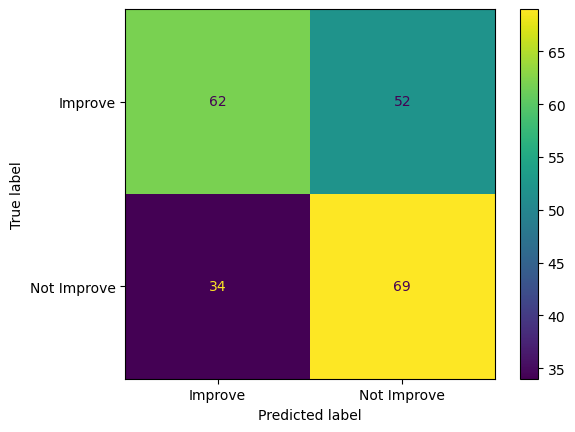

In [1928]:
cm = confusion_matrix(y_test, log_reg_y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
cm_display.plot()
plt.show()

### Decision Tree Classification

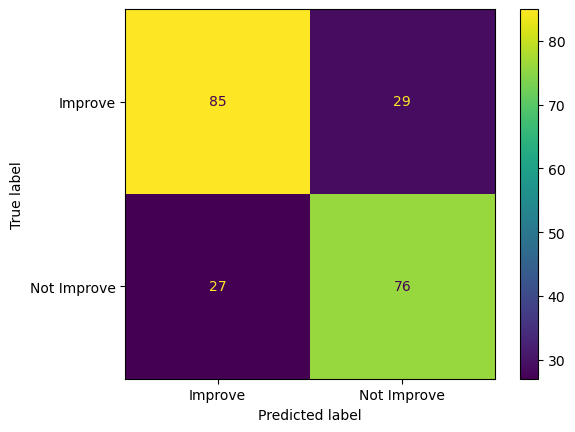

In [1931]:
cm = confusion_matrix(y_test, decision_tree_y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
cm_display.plot()
plt.show()

## Classification Report

### Logistic Regression

In [1941]:
print(classification_report(y_test, log_reg_y_pred))

              precision    recall  f1-score   support

           0       0.65      0.54      0.59       114
           1       0.57      0.67      0.62       103

    accuracy                           0.60       217
   macro avg       0.61      0.61      0.60       217
weighted avg       0.61      0.60      0.60       217



### Decision Tree Classification

In [1943]:
print(classification_report(y_test, decision_tree_y_pred))

              precision    recall  f1-score   support

           0       0.76      0.75      0.75       114
           1       0.72      0.74      0.73       103

    accuracy                           0.74       217
   macro avg       0.74      0.74      0.74       217
weighted avg       0.74      0.74      0.74       217



## ROC AUC

### Logistic Regression

In [1947]:
log_reg_y_pred_prob = log_reg_model.predict_proba(X_test)[:, 1]
roc_auc_score(y_test, log_reg_y_pred_prob)

0.6544881621529551

### Decision Tree Classification

In [1945]:
decision_tree_y_pred_prob = decision_tree_classifer_model.predict_proba(X_test)[:,1]
roc_auc_score(y_test, decision_tree_y_pred_prob)

0.7417390563788111